# Daily EIA Data

I found an EIA tool that reported the daily net generation breakdown for the lower 48.  I didn't check if its API endpoint is documented anywhere (who needs documentation when web browsers come with built-in developer tools?) but it's pretty straightforward and I played around with the data a bit.  Its monthly sums more or less match the generation numbers in Table 7.2b (see [this page](http://kevbase.com/site/report.html)), although there are some small differences, maybe because of excluding Hawaii and Alaska?  Unfortunately it doesn't seem to report any data prior to 2018-07-01.

Grab the entire dataset:

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt


def fetch(st, ed):
    url_template = 'https://www.eia.gov/electricity/930-api/region_data_by_fuel_type/series_data?type[0]=NG&respondent[0]=US48&start={st} 04:00:00&end={ed} 04:00:00&frequency=daily&timezone=Eastern'
    st = pd.to_datetime(st).strftime('%m%d%Y')
    ed = pd.to_datetime(ed).strftime('%m%d%Y')
    url = url_template.format(st=st, ed=ed)
    response = requests.get(url)
    json = response.json()
    df = pd.DataFrame(json[0]['data'])
    data = {}
    for i, row in df.iterrows():
        data[row['FUEL_TYPE_NAME']] = pd.Series(data=row['VALUES']['DATA'],
                                                index=row['VALUES']['DATES'])

    out = pd.DataFrame(data)
    out.index = pd.to_datetime(out.index)
    out = out[out.median().sort_values(ascending=False).index]
    return out

In [2]:
%%time
df = fetch('2018-07-01', '2021-08-10')  # no data from this API before 2018-07-01

CPU times: user 91 ms, sys: 7.89 ms, total: 98.9 ms
Wall time: 1.62 s


Nice and speedy, good job EIA!

First up, a look at the daily generation share for each major energy source:

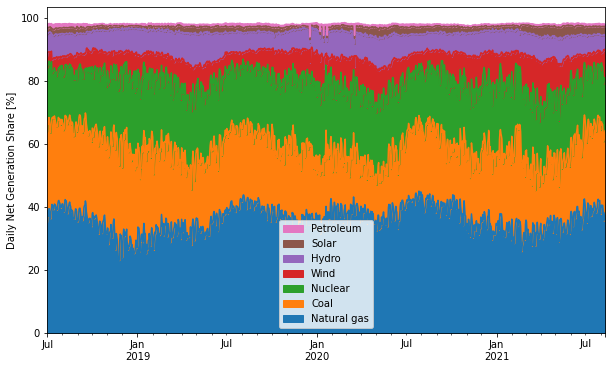

In [3]:
shares = df.divide(df.sum(axis=1), axis=0) * 100
shares = shares.drop(columns=['Other'])  # not interesting
ax = shares.plot.area(figsize=(10, 6))
ax.set_ylabel('Daily Net Generation Share [%]')
# reverse the legend entry order
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1]);

The same, but split out instead of stacked.  This view shows more detail for the smaller generation sources.

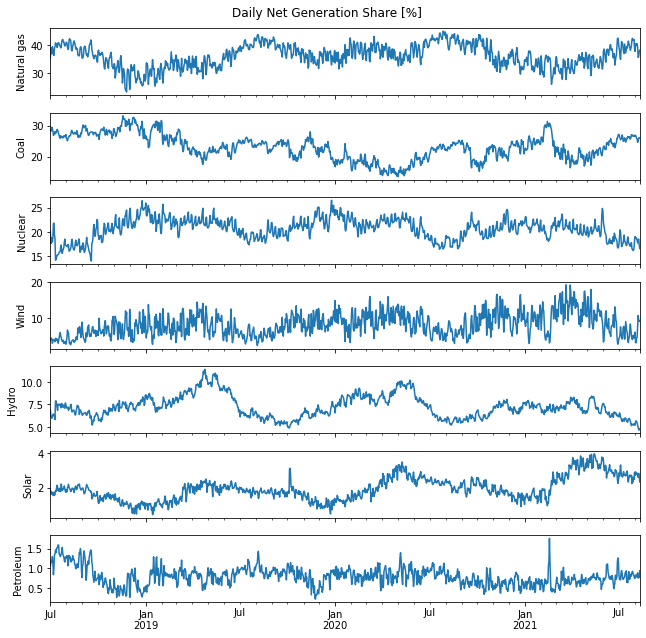

In [4]:
fig, axes = plt.subplots(len(shares.columns), 1, sharex=True, figsize=(9, 9))

for source, ax in zip(shares.columns, axes):
    shares[source].plot(ax=ax)
    ax.set_xlabel(None)
    ax.set_ylabel(source)
    ax.set_title(None)

fig.suptitle('Daily Net Generation Share [%]')
fig.tight_layout()

Some things I notice:
- What's up with the solar spike in October 2019?  Smells like a data error to me...
- Big petroleum spike in Feb 2021 maybe linked with the winter storms in Texas?
- I wonder if hydro is ramping down because of drought?  Or maybe it's just the same summer/fall trough seen in previous years
- Lots more day-to-day variation in wind than in solar

Nuclear seems to have a small periodic signal riding on top of the long-term variation.  In fact some of the others do too.  It's not very easy to see on top of the longer-term variation, so here's a quick normalization by 7-d average.  Also switching from daily share to daily generation:

In [5]:
def norm_7d(signal):
    signal_7d_avg = signal.resample('7d').mean()
    signal_7d_avg_ff = signal_7d_avg.reindex(signal.index, method='ffill')
    signal_norm = signal / signal_7d_avg_ff
    df_signal = signal_norm.to_frame().assign(dow=signal.index.dayofweek)
    return df_signal

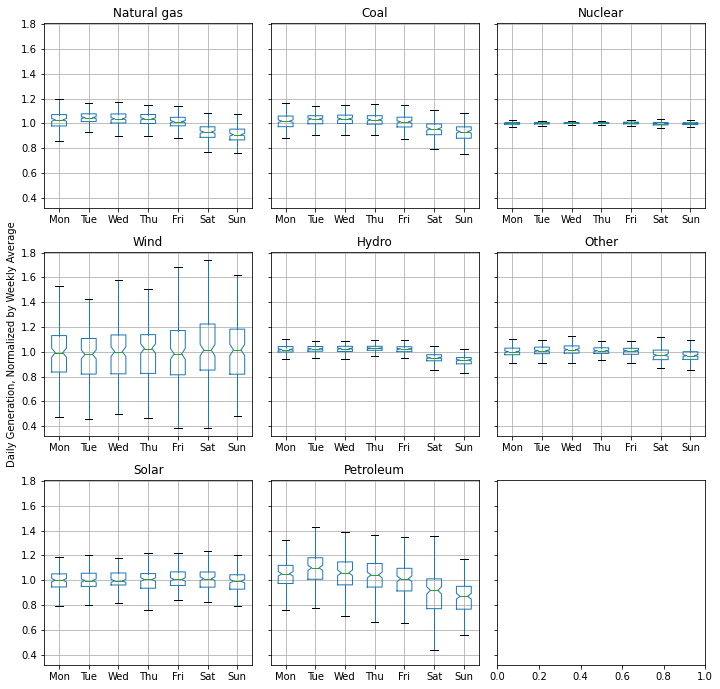

In [6]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharey=True)
axes = axes.ravel()

for source, ax in zip(df.columns, axes):
    df_share = norm_7d(df[source])
    df_share.boxplot(by='dow', notch=True, ax=ax, showfliers=False)
    ax.set_xlabel(None)
    ax.set_title(source)
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig.tight_layout()
axes[3].set_ylabel('Daily Generation, Normalized by Weekly Average')
fig.suptitle(None);

Sources with no significant weekly cycle: nuclear, wind, solar

Sources that produce less on weekends: natural gas, coal, hydro, petroleum

Is it as simple as which sources are dispatchable and which aren't?  Maybe.  Am I so ignorant that I don't understand even the basic dynamics of our electrical market?  Definitely.  It's still fun to play with the data though.